## Import Libraries

In [ ]:
!pip install xlrd

In [14]:
# !pip install python-dotenv
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from dotenv import load_dotenv
import os
os.environ['OGR_GEOMETRY_ACCEPT_UNCLOSED_RING'] = 'NO'
import zipfile
import shutil
import numpy as np
import pandas as pd
import folium
import branca.colormap as cm
from shapely.geometry import Point, LineString

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Retrieving api key
load_dotenv("../key.env")
api_key = os.getenv("API_KEY")

## Import Datasets

In [2]:
%run get_bus_info_function.ipynb
bus_services_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusServices", api_key)
bus_routes_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusRoutes", api_key)
bus_stops_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusStops", api_key)
train_stations = pd.read_excel("../datasets/Train_Stations.xls")

In [3]:
%run get_geospatial_function.ipynb
geospatial_train_path = "../datasets/geospatial_layer/TrainStation_Jul2024/RapidTransitSystemStation.shp"
geospatial_train_gdf = gpd.read_file(geospatial_train_path)
geospatial_train_gdf['geometry'] = geospatial_train_gdf['geometry'].buffer(0)

## Data Preprocessing

In [4]:
# Filter for Trunk Services
trunk_buses_df = bus_services_df[bus_services_df['Category'] == "TRUNK"]
trunk_buses_df = trunk_buses_df['ServiceNo']
trunk_bus_routes_df = pd.merge(trunk_buses_df, bus_routes_df,
                               on='ServiceNo', how='inner')
trunk_bus_routes_df = trunk_bus_routes_df[['ServiceNo', 'Direction', 'StopSequence', 'BusStopCode']]
geospatial_bus_route = pd.merge(trunk_bus_routes_df, bus_stops_df,
                                on='BusStopCode', how='inner')
geospatial_bus_route = geospatial_bus_route[['ServiceNo', 'Direction', 'StopSequence', 'BusStopCode', 'Latitude', 'Longitude']]
geospatial_bus_route.head()

,ServiceNo,Direction,StopSequence,BusStopCode,Latitude,Longitude
0,118,1,1,65009,1.403706,103.902243
1,118,1,2,65259,1.405352,103.901872
2,118,1,3,65409,1.406245,103.899575
3,118,1,4,65141,1.404548,103.897164
4,118,1,5,65431,1.402389,103.896736


## Bus Lines

In [6]:
# Ensure bus stops have the same CRS
geospatial_bus_route_gdf = gpd.GeoDataFrame(
    geospatial_bus_route,
    geometry=gpd.points_from_xy(geospatial_bus_route.Longitude, geospatial_bus_route.Latitude),
    crs="EPSG:4326"
)

# Group by each service and direction, and create LineStrings based on sorted StopSequence
def create_line(group):
    # Convert each stop in the group to a Point and create a LineString
    return LineString(group.sort_values('StopSequence').geometry.tolist())

# Apply the function to create a GeoDataFrame with LineStrings for each bus route
bus_routes_lines = geospatial_bus_route_gdf.groupby(['ServiceNo', 'Direction']).apply(create_line).reset_index()
bus_routes_lines.columns = ['ServiceNo', 'Direction', 'geometry']

# Convert to a GeoDataFrame
bus_routes_lines_gdf = gpd.GeoDataFrame(bus_routes_lines, geometry='geometry', crs="EPSG:4326")

# Check your final bus_routes_lines_gdf
print(bus_routes_lines_gdf.head())

  ServiceNo  Direction                                           geometry
0        10          1  LINESTRING (103.94339 1.35408, 103.94339 1.354...
1        10          2  LINESTRING (103.76988 1.29425, 103.76988 1.294...
2       100          1  LINESTRING (103.87169 1.35047, 103.87169 1.350...
3       100          2  LINESTRING (103.78932 1.31107, 103.78932 1.311...
4      100A          1  LINESTRING (103.87169 1.35047, 103.87205 1.346...


/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_41605/4088236509.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bus_routes_lines = geospatial_bus_route_gdf.groupby(['ServiceNo', 'Direction']).apply(create_line).reset_index()


## Train Lines

In [7]:
# Step 1: Union the geometries for the same station
unioned_gdf = geospatial_train_gdf.dissolve(by='STN_NAM_DE',aggfunc='first')

# Step 2: Calculate the centroid of the unioned polygon
unioned_gdf['centroid'] = unioned_gdf.centroid

# Optional Step: Replace geometry with centroid point
unioned_gdf['geometry'] = unioned_gdf['centroid']

# Reset index to clean up
unioned_gdf.reset_index(inplace=True)

# Function to normalize station names in train_stations_df
def normalize_station_name(name):
    return name.strip().upper()  # Ensure names are uppercase for consistent merging

# Apply normalization function to train_stations_df
train_stations['Normalized_Station'] = train_stations['MRT_Station'].apply(normalize_station_name)

# Create a column to append " MRT STATION" or " LRT STATION" based on the MRT_Line
train_stations['Station_MRT_LRT'] = train_stations.apply(
    lambda row: f"{row['Normalized_Station']} MRT STATION" if "LRT" not in row['MRT_Line'] else f"{row['Normalized_Station']} LRT STATION",
    axis=1
)

# Apply normalization to geospatial_train_df
# Strip ' MRT STATION' and ' LRT STATION' and normalize to uppercase
unioned_gdf['Normalized_Station'] = unioned_gdf['STN_NAM_DE'].str.strip().str.upper()

# Perform the merge on 'Station_MRT_LRT' from train_stations and 'Normalized_Station' from unioned_gdf
merged_train_stations = train_stations.merge(
    unioned_gdf,
    how='left',
    left_on='Station_MRT_LRT',
    right_on='Normalized_Station'
)

merged_train_stations = merged_train_stations[['Station_Code', 'MRT_Station', 'MRT_Line', 'TYP_CD_DES', 'geometry']]

#  Convert Pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_train_stations, geometry='geometry')

#  Reproject the GeoDataFrame to EPSG:4326 (WGS 84 - latitude/longitude)
gdf_4326 = gdf.to_crs(epsg=4326)

# Extract Longitude and Latitude from the reprojected geometries
gdf_4326['Longitude'] = gdf_4326.geometry.x
gdf_4326['Latitude'] = gdf_4326.geometry.y

#  Convert back to a Pandas DataFrame (if you don't need the geometry anymore)
geospatial_train_station = pd.DataFrame(gdf_4326)

geospatial_train_station = geospatial_train_station[['Station_Code', 'MRT_Station', 'MRT_Line', 'Longitude', 'Latitude']]
geospatial_train_station['Train_Line'] = geospatial_train_station['Station_Code'].str.extract(r'([A-Za-z]+)')
geospatial_train_station['Station_No'] = geospatial_train_station['Station_Code'].str.extract(r'(\d+)').fillna(1).astype(int)
geospatial_train_station.head()

/Users/yg/anaconda3/envs/DSA4264/lib/python3.11/site-packages/geopandas/geodataframe.py:1816: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


,Station_Code,MRT_Station,MRT_Line,Longitude,Latitude,Train_Line,Station_No
0,NS1,Jurong East,North-South Line,103.742263,1.333209,NS,1
1,NS2,Bukit Batok,North-South Line,103.749541,1.348997,NS,2
2,NS3,Bukit Gombak,North-South Line,103.751910,1.358672,NS,3
3,NS4,Choa Chu Kang,North-South Line,103.744369,1.385172,NS,4
4,NS5,Yew Tee,North-South Line,103.747402,1.397550,NS,5


In [8]:
# Convert to GeoDataFrame
train_stations_gdf = gpd.GeoDataFrame(
    geospatial_train_station,
    geometry=gpd.points_from_xy(geospatial_train_station.Longitude, geospatial_train_station.Latitude),
    crs="EPSG:4326"
)

# Step 2: Sort and group by train line to form continuous line segments for each line
train_stations_gdf = train_stations_gdf.sort_values(by=['Train_Line', 'Station_No'])

# Group by each train line to create LineString for each line
train_lines_gdf = train_stations_gdf.groupby('Train_Line').apply(
    lambda group: LineString(group.geometry.tolist()) if len(group) > 1 else None
).reset_index(name='geometry')

# Filter out rows where geometry is None (i.e., groups with less than 2 geometries)
train_lines_gdf = train_lines_gdf[train_lines_gdf['geometry'].notna()]

# Convert the result into a GeoDataFrame, which represents each train line as a LineString
train_lines_gdf = gpd.GeoDataFrame(train_lines_gdf, geometry='geometry', crs="EPSG:4326")

# Display the first few rows to confirm
print(train_lines_gdf.head())

  Train_Line                                           geometry
0         BP  LINESTRING (103.74455 1.38482, 103.74529 1.380...
1         CC  LINESTRING (103.84572 1.29938, 103.85066 1.296...
2         CE  LINESTRING (103.85908 1.28187, 103.85498 1.27570)
3         CG  LINESTRING (103.96205 1.33497, 103.98837 1.35731)
4         DT  LINESTRING (103.76157 1.37916, 103.76470 1.369...


/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_41605/3452923685.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_lines_gdf = train_stations_gdf.groupby('Train_Line').apply(


/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_41605/3950623142.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_lines))  # Using 'tab10' colormap for distinct colors


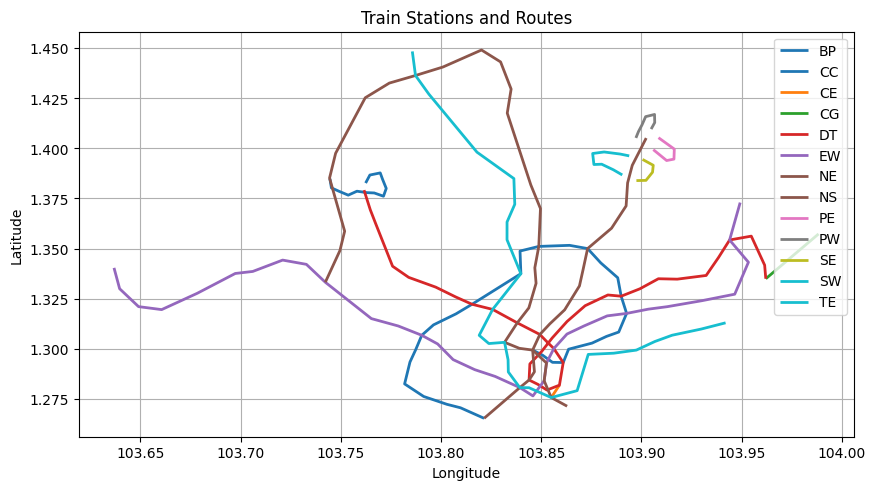

In [9]:
# Assuming you have train_lines_gdf with unique Train_Line values
unique_lines = train_lines_gdf['Train_Line'].unique()

# Create a colormap
colors = plt.cm.get_cmap('tab10', len(unique_lines))  # Using 'tab10' colormap for distinct colors

# Plot the bus routes (lines) and train stations (points)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each train line with a unique color
for i, line in enumerate(unique_lines):
    line_data = train_lines_gdf[train_lines_gdf['Train_Line'] == line]
    line_data.plot(ax=ax, color=colors(i), linewidth=2, label=line)

plt.legend()
plt.title("Train Stations and Routes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [18]:
# Step 1: Set up the base map centered around Singapore
singapore_lat, singapore_lon = 1.3521, 103.8198
m = folium.Map(location=[singapore_lat, singapore_lon], zoom_start=12, tiles='CartoDB positron')

# Step 2: Create a color map for the train lines
unique_lines = train_lines_gdf['Train_Line'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_lines))  # Using 'tab10' colormap for distinct colors

# Step 3: Add each train line to the map with a unique color
color_map_dict = {}  # Dictionary to keep track of colors assigned to each train line

for i, line in enumerate(unique_lines):
    line_data = train_lines_gdf[train_lines_gdf['Train_Line'] == line]
    
    # Convert GeoDataFrame to GeoJSON
    geo_json = line_data.to_json()

    # Get a distinct color for each line
    line_color = f"#{''.join([hex(int(c*255))[2:].zfill(2) for c in colors(i)[:3]])}"
    color_map_dict[line] = line_color  # Save color for legend

    # Add GeoJSON to folium map with unique color
    folium.GeoJson(
        geo_json,
        name=f"Train Line {line}",
        style_function=lambda feature, color=line_color: {
            'color': color,
            'weight': 3
        }
    ).add_to(m)

# Step 4: Add a Layer Control to toggle visibility
folium.LayerControl().add_to(m)

# Step 5: Optional: Add a legend to explain the colors (using folium directly to create a custom legend)
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: auto; 
            background-color: white; z-index: 1000; padding: 10px; border-radius: 5px;">
<h4>Train Lines Legend</h4>
<ul style="list-style-type: none; padding: 0;">
'''
for line, color in color_map_dict.items():
    legend_html += f'<li><span style="background:{color};width:15px;height:15px;display:inline-block;margin-right:10px;"></span>{line}</li>'

legend_html += '</ul></div>'

m.get_root().html.add_child(folium.Element(legend_html))

# Step 6: Save and Display the Map
m.save("../datasets/singapore_map_with_train_lines.html")
m



/var/folders/wd/kh32cc2j77q1912q774z4hw40000gn/T/ipykernel_41605/54382809.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_lines))  # Using 'tab10' colormap for distinct colors
